In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def compute_heart_rate(signal, sampling_rate=30, distance=None):
    """
    利用峰值检测计算信号的平均心率（BPM）

    Parameters:
        signal: 一维数组，表示连续的信号数据
        sampling_rate: 采样率（Hz），即每秒采样点数
        distance: 峰值之间的最小距离，默认为采样率的一半
    Returns:
        hr: 计算得到的心率（BPM）
        peaks: 检测到的峰值索引数组
    """
    if distance is None:
        distance = int(0.6 * sampling_rate)
    peaks, _ = find_peaks(signal, distance=distance)
    duration = len(signal) / sampling_rate  # 信号时长（秒）
    hr = (len(peaks) / duration) * 60       # 转换为 BPM
    print(hr)
    return hr, peaks

def compute_instantaneous_hr(signal, sampling_rate=30, window_length_sec=10, step_sec=1):
    """
    利用滑动窗口计算瞬时心率序列

    Parameters:
        signal: 一维数组，连续信号数据
        sampling_rate: 采样率（Hz）
        window_length_sec: 窗口时长（秒），默认为10秒
        step_sec: 滑动步长（秒），默认为1秒
    Returns:
        timestamps: 每个窗口中心对应的时间戳（秒）
        hr_list: 每个窗口内计算得到的心率（BPM）
    """
    window_length = int(window_length_sec * sampling_rate)
    step = int(step_sec * sampling_rate)
    hr_list = []
    timestamps = []
    for start in range(0, len(signal) - window_length + 1, step):
        window = signal[start:start+window_length]
        peaks, _ = find_peaks(window, distance=int(0.5 * sampling_rate))
        hr_window = (len(peaks) / window_length_sec) * 60
        hr_list.append(hr_window)
        timestamps.append((start + window_length // 2) / sampling_rate)
    return np.array(timestamps), np.array(hr_list)

In [9]:
output_folder = "/ltb_work/rppg-Toolbox_MMPD/test_results"

# 定义保存结果图的文件夹路径
result_plot_folder = "/ltb_work/rppg-Toolbox_MMPD/result_plots"
if not os.path.exists(result_plot_folder):
    os.makedirs(result_plot_folder)

subjects = [f.split('_')[0] for f in os.listdir(output_folder) if f.endswith('_pred.txt')]
subjects = sorted(set(subjects))

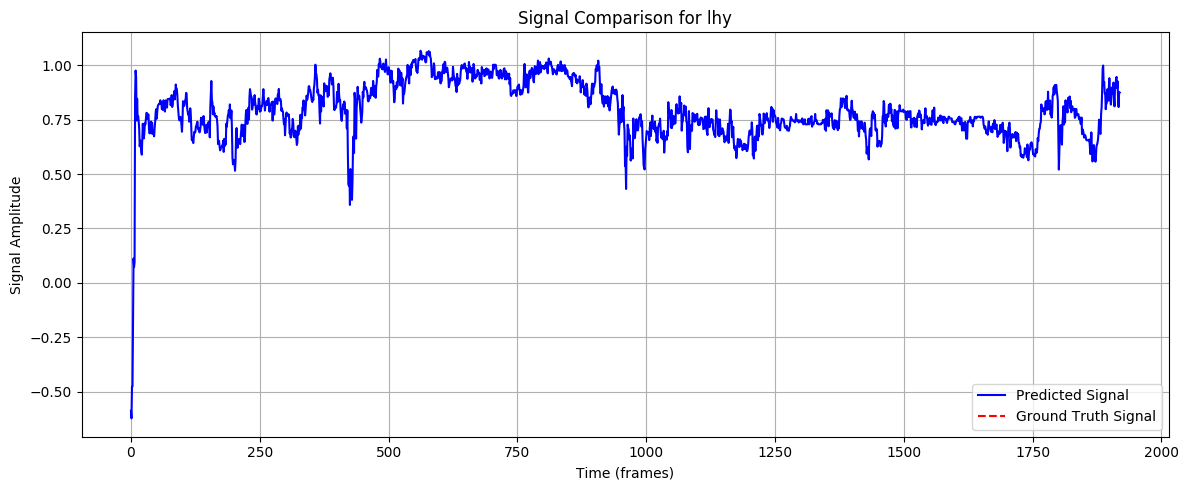

75.9375


ValueError: `x` must be a 1-D array

In [10]:

for subj in subjects:
    pred_path = os.path.join(output_folder, f"{subj}_pred.txt")
    label_path = os.path.join(output_folder, f"{subj}_label.txt")
    
    pred_signal = np.loadtxt(pred_path)
    label_signal = np.loadtxt(label_path)
    
    # ---------------------------
    # 绘制信号对比图，并保存图像
    # ---------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(pred_signal, label="Predicted Signal", color="blue")
    plt.plot(label_signal, label="Ground Truth Signal", color="red", linestyle="--")
    plt.title(f"Signal Comparison for {subj}")
    plt.xlabel("Time (frames)")
    plt.ylabel("Signal Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    signal_fig_path = os.path.join(result_plot_folder, f"{subj}_signal_comparison.png")
    plt.savefig(signal_fig_path)
    plt.show()
    plt.close()
    
    # ---------------------------
    # 计算整体心率并绘制柱状图对比
    # ---------------------------
    sampling_rate = 30  
    pred_hr, _ = compute_heart_rate(pred_signal, sampling_rate=sampling_rate)
    label_hr, _ = compute_heart_rate(label_signal, sampling_rate=sampling_rate)
    
    plt.figure(figsize=(6, 5))
    hr_values = [pred_hr, label_hr]
    hr_labels = ["Predicted HR", "Ground Truth HR"]
    colors = ["blue", "red"]
    bars = plt.bar(hr_labels, hr_values, color=colors, alpha=0.7)
    plt.title(f"Heart Rate Comparison for {subj}")
    plt.ylabel("Heart Rate (BPM)")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    hr_fig_path = os.path.join(result_plot_folder, f"{subj}_heart_rate_comparison.png")
    plt.savefig(hr_fig_path)
    plt.show()
    plt.close()
    
    # ----------------------------------------------
    # 计算并绘制瞬时心率随时间戳变化的对比图
    # ----------------------------------------------

    window_length_sec = 10
    step_sec = 1
    
    ts_pred, hr_pred_series = compute_instantaneous_hr(pred_signal, sampling_rate=sampling_rate, 
                                                       window_length_sec=window_length_sec, step_sec=step_sec)
    ts_label, hr_label_series = compute_instantaneous_hr(label_signal, sampling_rate=sampling_rate, 
                                                         window_length_sec=window_length_sec, step_sec=step_sec)
    
    plt.figure(figsize=(12, 5))
    plt.plot(ts_pred, hr_pred_series, label="Predicted HR", color="blue")
    plt.plot(ts_label, hr_label_series, label="Ground Truth HR", color="red", linestyle="--")
    plt.title(f"Instantaneous Heart Rate Comparison for {subj}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Heart Rate (BPM)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    instant_hr_fig_path = os.path.join(result_plot_folder, f"{subj}_instantaneous_hr_comparison.png")
    plt.savefig(instant_hr_fig_path)
    plt.show()
    plt.close()
